In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import pymysql
from sklearn.model_selection import train_test_split
import sequitur
from sequitur import models
import datetime

In [79]:
def load_data(filetype='sql'):
    if filetype == 'sql':
        dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
        data = pd.read_sql("SELECT * FROM SUMMARY", dbcon)
    elif filetype == 'csv':
        data = pd.read_csv('summary.csv')
    data.replace([1.1e+308], np.nan, inplace=True)
    data.fillna(np.nan, inplace=True)
    data.dropna(axis=1,how='all',inplace=True)
    #data = data.replace([np.nan], 0)
    return data

def OrdinalToDatetime(ordinal):
    try:
        plaindate = datetime.date.fromordinal(int(ordinal))
    except:
        plaindate = datetime.date.fromordinal(1)
    date_time = datetime.datetime.combine(plaindate, datetime.datetime.min.time())
    return date_time + datetime.timedelta(days=ordinal-int(ordinal))

def transform_timestamp(stamp):
        try:
            return OrdinalToDatetime(stamp/(24*3600*1000)).strftime('%d-%m-%Y %H:%M:%S.%f')
        except:
            return stamp

def convert_timestamp(data):
    timestamps = data[data.columns[0]].values
    data[data.columns[0]] = [transform_timestamp(time) for time in timestamps]
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
    return data

In [81]:
data = load_data('csv')
#data = data[25000:35000]

In [83]:
data = convert_timestamp(data)

In [84]:
data

,timestamp,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,...,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,2010-12-20 00:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-12-20 00:30:00.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-12-20 00:59:59.999997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-12-20 01:30:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-12-20 02:00:00.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,2015-08-04 00:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65404,2015-08-04 00:30:00.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65405,2015-08-04 00:59:59.999997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65406,2015-08-04 01:30:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
xl = pd.read_excel('quasi_static.xlsx')

In [139]:
def create_training_data(data):
    training_data = data.select_dtypes(include=np.number)
    #training_data = training_data.drop(data.columns[0], axis=1)
    training_data.dropna(axis=0, how='all', inplace=True)
    training_data.reset_index(drop=True)
    training_data = (training_data - training_data.mean())/training_data.std()
    return training_data

In [151]:
training_data = create_training_data(xl)

In [143]:
size = training_data.shape[1]

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(size, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, size)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [166]:
num_epochs=100
batch_size=100
learning_rate=1e-4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

training_tensor_data = torch.from_numpy(training_data[:10000].values.astype(np.float32))
testing_tensor_data = torch.from_numpy(training_data[10000:].values.astype(np.float32))
load = DataLoader(training_tensor_data, batch_size=batch_size, shuffle=False)

model = AutoEncoder()
loss_func = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)
model.train()

loss_list = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for idx, item in enumerate(load):
        # forward
        output = model(item.to(device))
        loss = loss_func(output, item)
        
        # backward
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
    loss_list.append(epoch_loss)

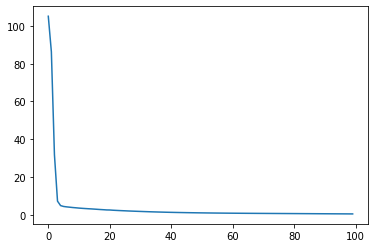

In [168]:
plt.plot(loss_list)

In [169]:
model.eval()
loss_dict = []
for i in range(len(testing_tensor_data)):
    data = testing_tensor_data[i]
    sample = model(data.to(device))
    loss = loss_func(data.to(device), sample)
    loss_dict.append(loss.item())

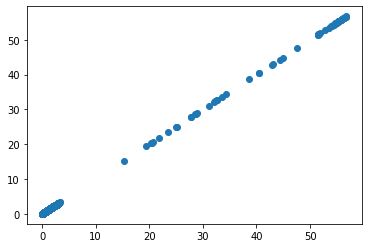

In [170]:
loss_sc = []
for i in loss_dict:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))

In [184]:
test_data = xl[10000:]
#est_data.index[np.argwhere(np.array(loss_dict)>np.mean(loss_dict)+np.std(loss_dict))]
np.argwhere(np.array(loss_dict)>np.mean(loss_dict)+np.std(loss_dict)).reshape(-1)

array([ 70047,  70048,  70049, ..., 126509, 126517, 126726], dtype=int64)

In [185]:
test_data.iloc[np.argwhere(np.array(loss_dict)>np.mean(loss_dict)+np.std(loss_dict)).reshape(-1)]

,Timestamp,TZ,Thermocouple_1 (degC),Thermocouple_3 (degC),Thermocouple_5 (degC),Thermocouple_7 (degC),Thermocouple_9 (degC),Thermocouple_11 (degC),Thermocouple_13 (degC),Thermocouple_15 (degC),...,Strain_7 (ppm),Strain_8 (ppm),Strain_9 (ppm),Strain_10 (ppm),Displacement_1 (ppm),Displacement_2 (ppm),Displacement_3 (ppm),Displacement_4 (ppm),Tilt (mV),Tilt_temp (Ohms)
80047,2013-11-28 02:38:00.000,n,17.925714,17.947170,17.964258,17.917170,18.011536,17.968626,18.067354,18.037356,...,-54.158292,80.488128,9.311032,-129.01074,1158.7406,2100.5506,1129.5138,2466.9188,263.375360,351.67700
80048,2013-11-28 02:39:00.001,n,17.939538,17.952452,17.956626,17.935174,18.003904,17.982448,18.094086,18.051180,...,-53.202240,81.991216,10.541052,-128.86520,1159.0360,2100.3650,1129.3524,2465.8852,263.267880,351.69136
80049,2013-11-28 02:40:00.003,n,17.924634,17.963178,17.967546,17.911722,18.006088,17.976090,18.070640,18.044820,...,-53.888296,81.857880,9.862448,-128.04562,1159.5118,2101.3450,1129.9710,2466.7950,202.345020,351.66956
80050,2013-11-28 02:41:00.005,n,17.917152,17.942976,17.942976,17.891326,17.994428,17.960064,18.076068,18.028796,...,-54.294292,81.316496,9.723930,-128.86840,1159.0648,2100.9498,1129.8860,2466.7202,150.048000,351.66956
80051,2013-11-28 02:42:00.007,n,17.904240,17.930064,17.938606,17.882784,17.990062,17.947152,18.058980,18.020250,...,-54.021612,81.447832,9.996140,-129.00434,1158.6010,2100.1092,1129.3040,2465.8050,268.852840,351.65492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136501,2014-01-06 07:32:00.000,n,14.140746,14.231192,14.257086,14.192538,14.261466,14.235572,14.261466,14.235572,...,-23.415980,112.550460,36.792856,-102.17274,1092.0912,2036.4742,1019.0040,2393.7508,-31.838386,352.24376
136507,2014-01-06 07:38:00.008,n,14.147262,14.255034,14.302444,14.224760,14.293876,14.246274,14.293876,14.263602,...,-24.937986,110.804960,35.027520,-104.94014,1093.2300,2037.6740,1025.2350,2397.0440,-31.666160,352.25932
136509,2014-01-06 07:40:00.000,n,14.186342,14.276784,14.315624,14.250890,14.341516,14.289540,14.358652,14.276784,...,-25.616078,110.251560,34.613512,-104.80188,1093.7352,2039.4118,1028.2934,2398.9144,-31.384178,352.36804
136517,2014-01-06 07:48:00.011,n,14.332220,14.448544,14.491758,14.414086,14.491758,14.435598,14.517458,14.439788,...,-25.479028,110.373740,34.890024,-104.79402,1097.4648,2043.1138,1038.8456,2405.0042,-31.586632,352.41136
